# Recurrent Neural Networks

Adapted from Building Machine Learning and Deep Learning Models on Google Cloud Platform - Ekaba Bisong

## Univariate Timeseries

In [2]:
# import packages
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
# load data
parse_date = lambda dates: pd.datetime.strptime(dates, '%d-%m')
data = pd.read_csv('nigeria-power-consumption.csv', parse_dates=['Month'], index_col='Month',
                   date_parser=parse_date,
                   engine='python', skipfooter=2)

/Users/fmezaoba/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [4]:
# print column name
data.columns

Index(['Nigeria power consumption'], dtype='object')

In [5]:
# change column names
data.rename(columns={'Nigeria power consumption': 'power-consumption'},
            inplace=True)

In [6]:
# split in training and evaluation set
data_train, data_eval = train_test_split(data, test_size=0.2, shuffle=False)

In [7]:
# MinMaxScaler - center and scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_train = scaler.fit_transform(data_train)
data_eval = scaler.fit_transform(data_eval)

In [58]:
# adjust univariate data for timeseries prediction
def convert_to_sequences(data, sequence, is_target=False):
    temp_df = []
    for i in range(len(data) - sequence):
        if is_target:
            temp_df.append(data[(i+1): (i+1) + sequence])
        else:
            temp_df.append(data[i: i + sequence])
    return np.array(temp_df)

In [59]:
# parameters
time_steps = 20
batch_size = 50

In [60]:
# create training and testing data
train_x = convert_to_sequences(data_train, time_steps, is_target=False)
train_y = convert_to_sequences(data_train, time_steps, is_target=True)

eval_x = convert_to_sequences(data_eval, time_steps, is_target=False)
eval_y = convert_to_sequences(data_eval, time_steps, is_target=True)

In [61]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=train_x.shape[1:],
                               return_sequences=True))
model.add(tf.keras.layers.Dense(1))

# compile the model
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

In [62]:
# print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 128)           66560     
_________________________________________________________________
dense_4 (Dense)              (None, 20, 1)             129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [63]:
# create dataset pipeline
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_x, train_y)).shuffle(len(train_x)).repeat().batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((eval_x, eval_y)).batch(batch_size)

In [64]:
# train the model
history = model.fit(train_ds, epochs=10,
                    steps_per_epoch=500)

Epoch 1/10
500/500 [==============================] - 9s 18ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 3/10
500/500 [==============================] - 8s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/10
500/500 [==============================] - 8s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 5/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 6/10
500/500 [==============================] - 9s 19ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 7/10
500/500 [==============================] - 9s 17ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 8/10
500/500 [==============================] - 9s 18ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 9/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0014 - mean_squared_error: 0.0014
E

In [65]:
# evaluate the model
loss, mse = model.evaluate(test_ds)

1/1 [==============================] - 0s 241ms/step - loss: 0.0422 - mean_squared_error: 0.0422


In [66]:
print('Test loss: {:.4f}'.format(loss))
print('Test mse: {:.4f}'.format(mse))

Test loss: 0.0422
Test mse: 0.0422


In [67]:
# predict
y_pred = model.predict(eval_x)

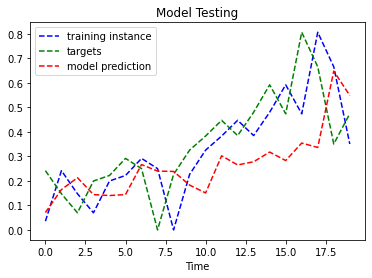

In [68]:
# plot predicted sequence
plt.title("Model Testing", fontsize=12)
plt.plot(eval_x[0,:,0], "b--", markersize=10, label="training instance")
plt.plot(eval_y[0,:,0], "g--", markersize=10, label="targets")
plt.plot(y_pred[0,:,0], "r--", markersize=10, label="model prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()
# plt.savefig('lstm-ts-model-testing.png', dpi=800)

## Multivariate Timeseries

In [69]:
# import packages
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [70]:
# load data
data = pd.read_csv('dow_jones_index.data', parse_dates=['date'], index_col='date')

In [71]:
# print column name
data.columns

Index(['quarter', 'stock', 'open', 'high', 'low', 'close', 'volume',
       'percent_change_price', 'percent_change_volume_over_last_wk',
       'previous_weeks_volume', 'next_weeks_open', 'next_weeks_close',
       'percent_change_next_weeks_price', 'days_to_next_dividend',
       'percent_return_next_dividend'],
      dtype='object')

In [72]:
# print column datatypes
data.dtypes

quarter                                 int64
stock                                  object
open                                   object
high                                   object
low                                    object
close                                  object
volume                                  int64
percent_change_price                  float64
percent_change_volume_over_last_wk    float64
previous_weeks_volume                 float64
next_weeks_open                        object
next_weeks_close                       object
percent_change_next_weeks_price       float64
days_to_next_dividend                   int64
percent_return_next_dividend          float64
dtype: object

In [73]:
# parameters
outputs = 1
stock ='BAC'  # Bank of America

In [74]:
def clean_dataset(data):
    # strip dollar sign from `object` type columns
    col = ['open', 'high', 'low', 'close', 'next_weeks_open', 'next_weeks_close']
    data[col] = data[col].replace({'\$': ''}, regex=True)
    # drop NaN
    data.dropna(inplace=True)
    # rearrange columns
    columns = ['quarter', 'stock', 'open', 'high', 'low', 'close', 'volume',
       'percent_change_price', 'percent_change_volume_over_last_wk',
       'previous_weeks_volume', 'next_weeks_open', 'next_weeks_close',
       'days_to_next_dividend', 'percent_return_next_dividend',
       'percent_change_next_weeks_price']
    data = data[columns]
    return data

In [75]:
def data_transform(data):
    # select stock data belonging to Bank of America
    data = data[data.stock == stock]
    # adjust target(t) to depend on input (t-1)
    data.percent_change_next_weeks_price = data.percent_change_next_weeks_price.shift(-1)
    # remove nans as a result of the shifted values
    data = data.iloc[:-1,:]
    # split quarter 1 as training data and quarter 2 as testing data
    train_df = data[data.quarter == 1]
    test_df = data[data.quarter == 2]   
    return (np.array(train_df), np.array(test_df))

In [76]:
def normalize_and_scale(train_df, test_df):
    # remove string columns and convert to float
    train_df = train_df[:,2:].astype(float,copy=False)
    test_df = test_df[:,2:].astype(float,copy=False)
    # MinMaxScaler - center and scale the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))    
    train_df_scale = scaler.fit_transform(train_df[:,2:])
    test_df_scale = scaler.fit_transform(test_df[:,2:])  
    return (scaler, train_df_scale, test_df_scale)

In [77]:
# clean the dataset
data = clean_dataset(data)

In [79]:
# select Dow Jones stock and split into training and test sets
train_df, test_df = data_transform(data)

/Users/fmezaoba/miniconda3/envs/ML/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [80]:
# scale the data
scaler, train_df_scaled, test_df_scaled = normalize_and_scale(train_df, test_df)

In [81]:
# split train/ test
train_X, train_y = train_df_scaled[:, :-1], train_df_scaled[:, -1]
test_X, test_y = test_df_scaled[:, :-1], test_df_scaled[:, -1]

In [82]:
# reshape inputs to 3D array
train_X = train_X[:,None,:]
test_X = test_X[:,None,:]

In [83]:
# reshape outputs
train_y = np.reshape(train_y, (-1,outputs))
test_y = np.reshape(test_y, (-1,outputs))

In [84]:
# model parameters
batch_size = int(train_X.shape[0]/5)
length = train_X.shape[0]

In [85]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(128, input_shape=train_X.shape[1:],
                               return_sequences=True))
model.add(tf.keras.layers.GRU(100, return_sequences=True))
model.add(tf.keras.layers.GRU(64))
model.add(tf.keras.layers.Dense(1))

# compile the model
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

In [86]:
# print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 128)            53376     
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 100)            68700     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 153,821
Trainable params: 153,821
Non-trainable params: 0
_________________________________________________________________


In [87]:
# create dataset pipeline
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_X, train_y)).shuffle(len(train_X)).repeat().batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(batch_size)

In [88]:
# train the model
history = model.fit(train_ds, epochs=15,
                    steps_per_epoch=500)

Epoch 1/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0256 - mean_squared_error: 0.0256
Epoch 2/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3/15
500/500 [==============================] - 2s 4ms/step - loss: 9.2367e-05 - mean_squared_error: 9.2367e-05
Epoch 4/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 5/15
500/500 [==============================] - 2s 4ms/step - loss: 7.7830e-07 - mean_squared_error: 7.7830e-07
Epoch 6/15
500/500 [==============================] - 2s 4ms/step - loss: 2.2525e-04 - mean_squared_error: 2.2525e-04
Epoch 7/15
500/500 [==============================] - 2s 4ms/step - loss: 7.8908e-04 - mean_squared_error: 7.8908e-04
Epoch 8/15
500/500 [==============================] - 2s 4ms/step - loss: 3.4327e-04 - mean_squared_error: 3.4327e-04
Epoch 9/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0012

In [89]:
# evaluate the model
loss, mse = model.evaluate(test_ds)

6/6 [==============================] - 0s 61ms/step - loss: 0.1827 - mean_squared_error: 0.1827


In [90]:
print('Test loss: {:.4f}'.format(loss))
print('Test mse: {:.4f}'.format(mse))

Test loss: 0.1827
Test mse: 0.1827


In [91]:
# predict
y_pred = model.predict(test_X)

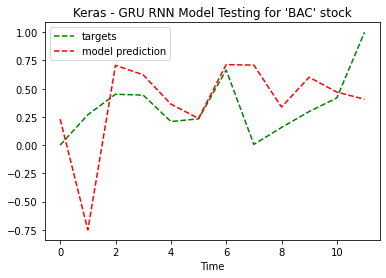

In [92]:
# plot
plt.figure(1)
plt.title("Keras - GRU RNN Model Testing for '{}' stock".format(stock), fontsize=12)
plt.plot(test_y, "g--", markersize=10, label="targets")
plt.plot(y_pred, "r--", markersize=10, label="model prediction")
plt.legend()
plt.xlabel("Time")
plt.show()
# plt.savefig('gru-bac-model.png', dpi=800)